In [1]:
#import libraries
import torch
from torchvision import datasets, transforms
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define transforms
my_transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))])

# Load the MNIST dataset
train = datasets.MNIST(root='/.data', train=True, download=True, transform=my_transform)
test = datasets.MNIST(root='/.data', train=False, download=True, transform=my_transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.55MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.71MB/s]


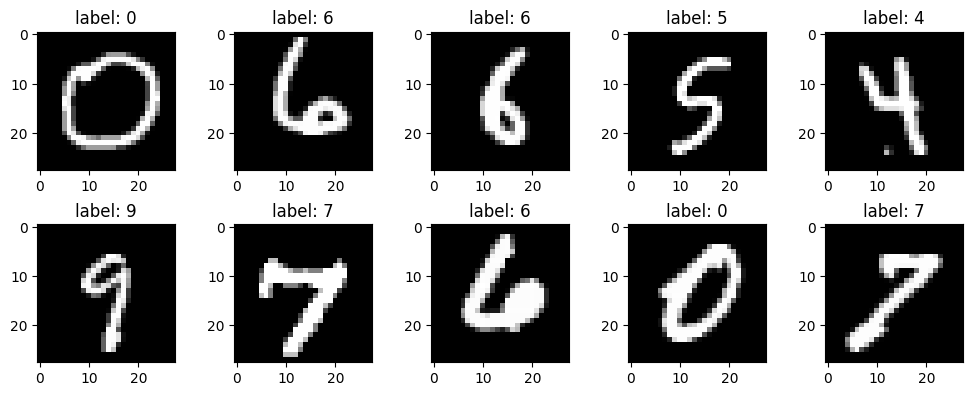

In [3]:
# Show some examples from the MNIST dataset
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
for i in range(2):
  for j in range(5):
    idx = np.random.randint(len(train))
    image, label = train[idx]
    ax[i, j].imshow(image.squeeze(), cmap='gray')
    ax[i, j].set_title(f'label: {label}')
plt.tight_layout()
plt.show()

In [4]:
def create_triplets(dataset):
  """
  Create triplets of images from a given dataset.

  Args:
      dataset: A PyTorch dataset object.

  Returns:
      A list of triplets, where each triplet is a tuple (anchor, positive, negative),
      and each element in the tuple is a PyTorch tensor of shape (1, 28, 28).
  """
  triplets = []
  for i in range(len(dataset)):
      # Select anchor image
      anchor_img, anchor_lbl = dataset[i]
      anchor_img = torch.from_numpy(anchor_img.numpy())

      # Select positive image with the same label as the anchor image
      positive_indices = np.where(dataset.targets == anchor_lbl)[0]
      positive_idx = np.random.choice(positive_indices)
      positive_img, _ = dataset[positive_idx]
      positive_img = torch.from_numpy(positive_img.numpy())

      # Select negative image with a different label than the anchor image
      negative_indices = np.where(dataset.targets != anchor_lbl)[0]
      negative_idx = np.random.choice(negative_indices)
      negative_img, _ = dataset[negative_idx]
      negative_img = torch.from_numpy(negative_img.numpy())

      triplets.append(((anchor_img, positive_img, negative_img)))

  return triplets

In [5]:
# Create Siamese triplets from the dataset
train_triplets = create_triplets(train)
test_triplets = create_triplets(test)

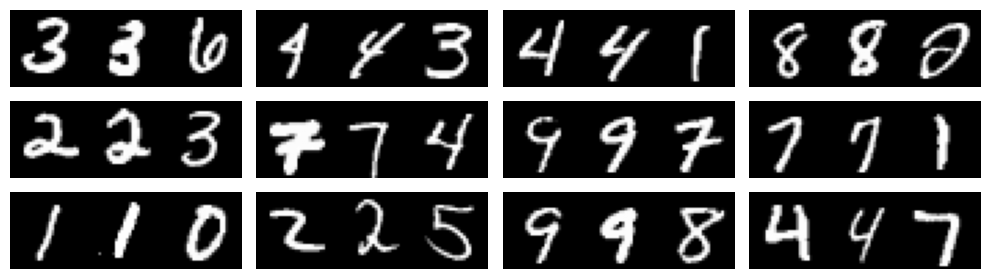

In [6]:
# Display some random triplets
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 3))
for i in range(3):
  for j in range(4):
    idx = np.random.randint(len(train_triplets))
    anchor, positive, negative = train_triplets[idx]
    ax[i, j].imshow(torch.cat([anchor, positive, negative], dim=2).squeeze(), cmap='gray')
    ax[i, j].axis('off')
plt.tight_layout()
plt.show()

In [7]:
# Define a function to create a DataLoader for the triplets
def create_dataloader(triplets, batch_size):
  """
    Create a DataLoader for a given set of triplets.
  """
  dataset = torch.utils.data.TensorDataset(*[torch.stack(t) for t in zip(*triplets)])
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
  return dataloader

In [8]:
# Create a DataLoader for the triplets
batch_size = 28
num_epochs = 2
train_dataloader = create_dataloader(train_triplets, batch_size)
test_dataloader = create_dataloader(test_triplets, batch_size)

In [21]:
class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)

        # Fully Conected layers
        self.fc1 = nn.Linear(7 * 7 * 64, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x1, x2):
        # Forward pass for first input
        out1 = self.conv1(x1)
        out1 = nn.functional.relu(out1)
        out1 = nn.functional.max_pool2d(out1, kernel_size=2)
        out1 = self.conv2(out1)
        out1 = nn.functional.relu(out1)
        out1 = nn.functional.max_pool2d(out1, kernel_size=2)
        out1 = out1.view(out1.size(0), -1)
        out1 = self.fc1(out1)
        out1 = nn.functional.relu(out1)
        out = self.fc2(out1)

        # Forward pass for second input
        out2 = self.conv1(x2)
        out2 = nn.functional.relu(out2)
        out2 = nn.functional.max_pool2d(out2, kernel_size=2)
        out2 = self.conv2(out2)
        out2 = nn.functional.relu(out2)
        out2 = nn.functional.max_pool2d(out2, kernel_size=2)
        out2 = out2.view(out2.size(0), -1)
        out2 = self.fc1(out2)
        out2 = nn.functional.relu(out2)
        out = self.fc2(out2)

        return out1, out2

In [10]:
def test_model(model, test_dataloader):
    """
    Evaluate the model on the test set and return the accuracy.
    """
    # Set the model to evaluation mode
    model.eval()

    # Keep track of the number of correct predictions
    num_correct = 0

    # Iterate over the test set
    for batch_idx, batch in enumerate(test_dataloader):

        # Extract the anchor, positive, and negative images from the batch
        anchor_imgs, positive_imgs, negative_imgs = batch

        # Forward pass
        anchor_out, positive_out = model(anchor_imgs, positive_imgs)
        anchor_out, negative_out = model(anchor_imgs, negative_imgs)

        # Calculate the distances between the anchor and positive/negative embeddings
        pos_dist = nn.functional.pairwise_distance(anchor_out, positive_out)
        neg_dist = nn.functional.pairwise_distance(anchor_out, negative_out)

        # Compute the binary classification labels (1 if positive pair, 0 if negative pair)
        labels = (pos_dist < neg_dist).float()

        # Compute the number of correct predictions
        num_correct += torch.sum(labels).item()

    # Compute the accuracy
    accuracy = num_correct / len(test_dataloader.dataset)

    # print the accuracy
    print(f'Test Accuracy: {accuracy}')

    return accuracy

In [22]:
# Instantiate the model and define the optimizer
model = SiameseNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
criterion = nn.TripletMarginLoss(margin=1.0)

# Set the model to train mode
model.train()

# Train the model
for epoch in range(num_epochs):
    for batch_idx, batch in enumerate(train_dataloader):
        # Zero the gradients
        optimizer.zero_grad()

        # Extract the anchor, positive, and negative images from the batch
        anchor_imgs, positive_imgs, negative_imgs = batch

        # Forward pass
        anchor_out, positive_out = model(anchor_imgs, positive_imgs)
        anchor_out, negative_out = model(anchor_imgs, negative_imgs)

        # Calculate the loss
        loss = criterion(anchor_out, positive_out, negative_out)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Print progress
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}, Batch_index {batch_idx}, Loss {loss.item()}")

    # Evaluate the model on the test set
    test_model(model, test_dataloader)

Epoch 1, Batch_index 0, Loss 0.6553616523742676
Epoch 1, Batch_index 100, Loss 0.08643670380115509
Epoch 1, Batch_index 200, Loss 0.050525955855846405
Epoch 1, Batch_index 300, Loss 0.047937460243701935
Epoch 1, Batch_index 400, Loss 0.030201861634850502
Epoch 1, Batch_index 500, Loss 0.0
Epoch 1, Batch_index 600, Loss 0.0
Epoch 1, Batch_index 700, Loss 0.0
Epoch 1, Batch_index 800, Loss 0.20125830173492432
Epoch 1, Batch_index 900, Loss 0.02867167256772518
Epoch 1, Batch_index 1000, Loss 0.1418357640504837
Epoch 1, Batch_index 1100, Loss 0.026729345321655273
Epoch 1, Batch_index 1200, Loss 0.0029593196231871843
Epoch 1, Batch_index 1300, Loss 0.0
Epoch 1, Batch_index 1400, Loss 0.0
Epoch 1, Batch_index 1500, Loss 0.0
Epoch 1, Batch_index 1600, Loss 0.0
Epoch 1, Batch_index 1700, Loss 0.1877167969942093
Epoch 1, Batch_index 1800, Loss 0.02031799778342247
Epoch 1, Batch_index 1900, Loss 0.0
Epoch 1, Batch_index 2000, Loss 0.026496121659874916
Epoch 1, Batch_index 2100, Loss 0.0301624704

In [34]:
def plot_test_triplets(model, dataloader, num_triplets=5):
    # Select a random subset of triplets from the test set
    triplet = iter(dataloader)
    triplets = next(triplet)
    anchor_imgs, positive_imgs, negative_imgs = triplets

    # Make predictions on each triplet and plot the results
    for idx in range(num_triplets):
        # Select one triplet
        anchor_img, positive_img, negative_img = anchor_imgs[idx], positive_imgs[idx], negative_imgs[idx]

        # Make predictions on the anchor, positive, and negative images
        anchor_img_tens = torch.tensor(anchor_img.unsqueeze(0))
        positive_img_tens = torch.tensor(positive_img.unsqueeze(0))
        negative_img_tens = torch.tensor(negative_img.unsqueeze(0))
        anchor_pred, _ = model(anchor_img_tens, anchor_img_tens)
        positive_pred, _ = model(positive_img_tens, positive_img_tens)
        negative_pred, _ = model(negative_img_tens, negative_img_tens)

        # Select the embeddings from the tuples and convert them into tensors
        anchor_pred = anchor_pred.squeeze()
        positive_pred = positive_pred.squeeze()
        negative_pred = negative_pred.squeeze()

        # Compute the distances between the embeddings
        pos_dist = nn.functional.pairwise_distance(anchor_pred, positive_pred)
        neg_dist = nn.functional.pairwise_distance(anchor_pred, negative_pred)

        # Plot the triplet images and their distances
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
        ax1.imshow(anchor_img.permute(1, 2, 0))
        ax1.set_title('Anchor')
        ax2.imshow(positive_img.permute(1, 2, 0))
        ax2.set_title('Positive')
        ax3.imshow(negative_img.permute(1, 2, 0))
        ax3.set_title('Negative')
        fig.suptitle(f'Distance. pos: {pos_dist.item():.2f}, neg: {neg_dist.item():.2f}')
        plt.show()

<ipython-input-34-de6ccd0b8587>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  anchor_img_tens = torch.tensor(anchor_img.unsqueeze(0))
<ipython-input-34-de6ccd0b8587>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_img_tens = torch.tensor(positive_img.unsqueeze(0))
<ipython-input-34-de6ccd0b8587>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  negative_img_tens = torch.tensor(negative_img.unsqueeze(0))


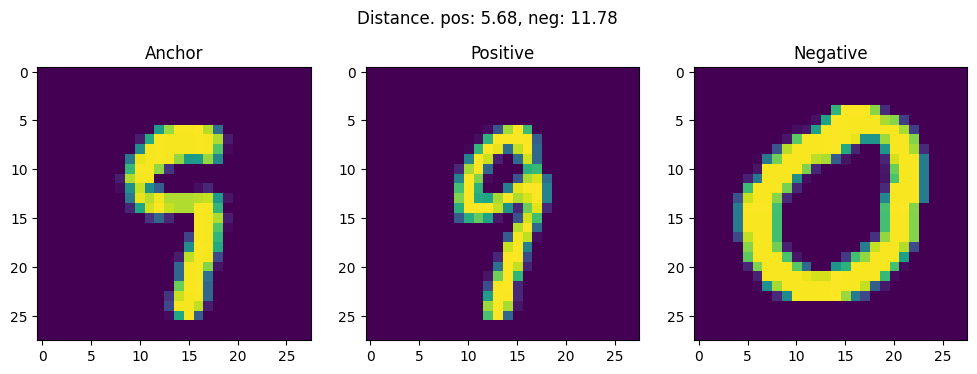

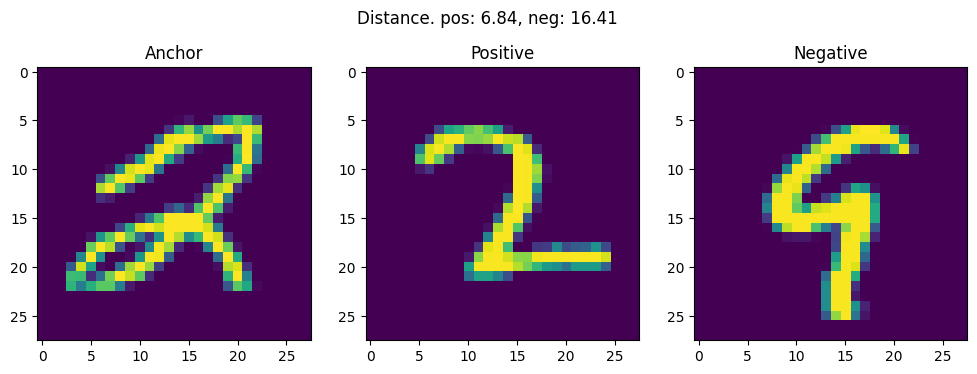

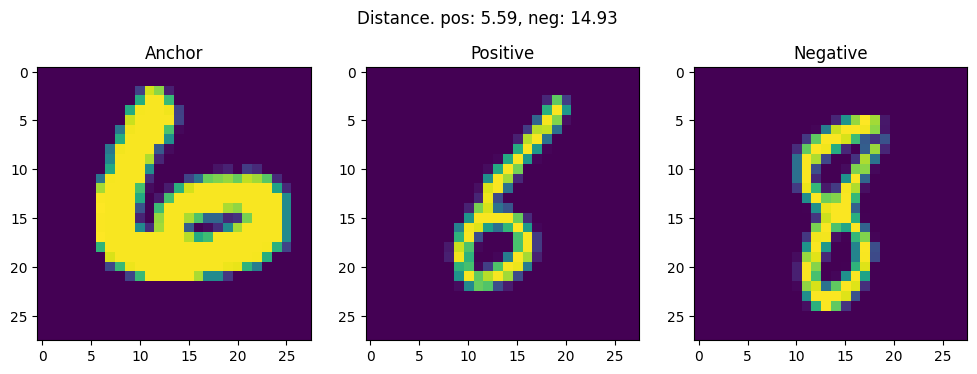

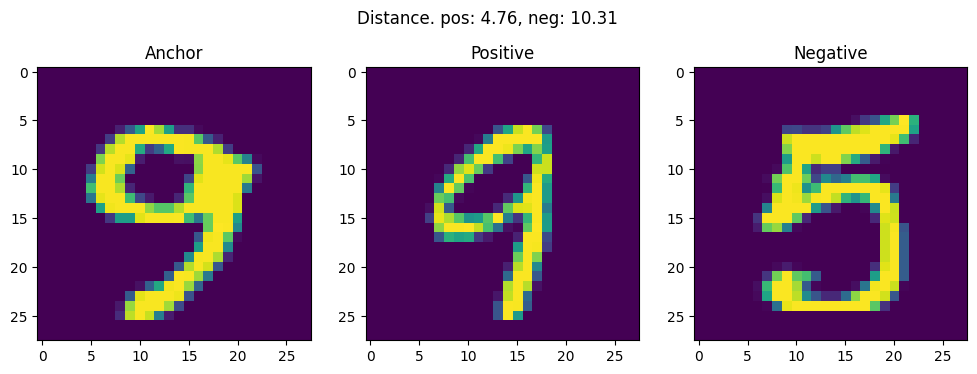

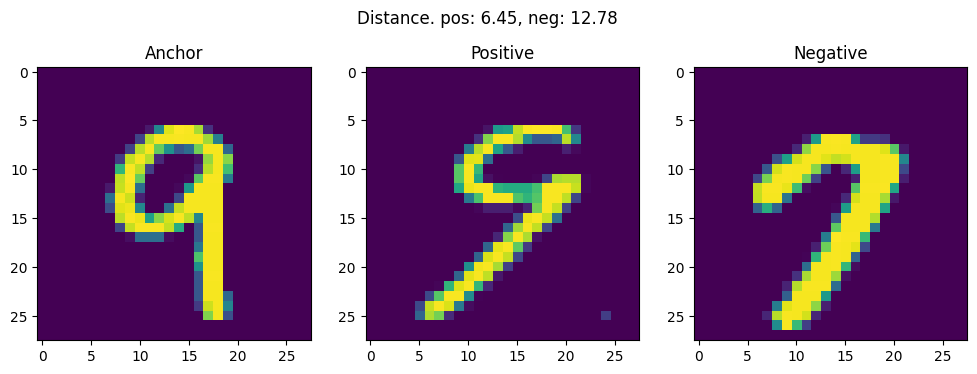

In [35]:
# Plot test triplets with their distance values as labels
plot_test_triplets(model, test_dataloader);